In [1]:
from settings import *

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

prices는 현재 공휴일이 제외 되지 않았다. 

TODO:

1. 공휴일 제외 데이터를 만들어서(kospi기준) 백테스팅 필요

In [3]:
prices = pd.read_csv('data/dollar_assets.csv', index_col=0, parse_dates=True)
prices.head(1)

,달러,나스닥100,다우
Date,,,
2001-01-02,1278,2128.780,10646.150


In [4]:
def AMS(x):
    ''' x : Series (DataFrame의 컬럼)
        x[-1] : 기준일. x의 현재값
        (오늘날짜/과거날짜 - 1) > 0 보다 크면 1, 아니면 0
        => 오늘날짜/과거날짜 > 1 => 오늘날짜 > 과거날짜  => x[-1] > x
    '''
    # print(f"{list(np.where(x[-1]>x, 1, 0)[:-1])}, {len(np.where(x[-1]>x, 1, 0)[:-1])}")
    return np.mean(np.where(x[-1]>x, 1, 0)[:-1]) # 당일 날짜 비교는 제외해준다 [:-1]    

In [5]:
target_weights = pd.DataFrame()
for c in ["나스닥100", "다우"]:
    target_weights[c] = prices[c].rolling(365).apply(AMS)
target_weights = target_weights*0.5
target_weights['달러'] = 1.0 - target_weights.sum(axis=1)

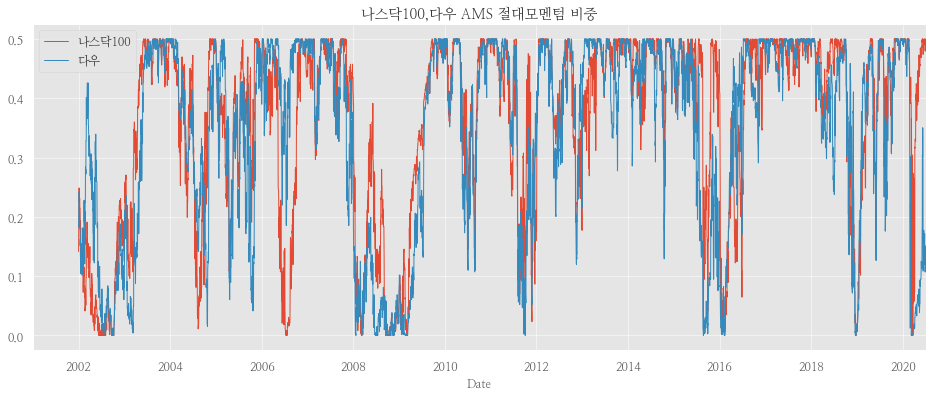

In [6]:
target_weights[['나스닥100', '다우']].plot(figsize=(16,6), title='나스닥100,다우 AMS 절대모멘텀 비중', legend=True);

In [7]:
tickers = prices.columns

In [8]:
나스닥다우동일비중 =bt.Strategy(
    "나스닥다우동일비중",
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectThese(['나스닥100', '다우']),
        bt.algos.WeighEqually(),
#         bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)

In [9]:
나스닥다우동일비중AMS = bt.Strategy(
    '나스닥다우동일비중AMS',
    [
        bt.algos.RunAfterDate('2002-1-2'),
        bt.algos.RunMonthly(),
        bt.algos.SelectThese(['나스닥100', '다우', '달러']),
        bt.algos.WeighTarget(target_weights),
        # WeighEquallyWithoutCash(target_weights, cash='현금'),
#         bt.algos.PrintTempData(),
        bt.algos.Rebalance()
    ]
)

In [10]:
bt_나스닥다우동일비중 = bt.Backtest(나스닥다우동일비중, prices)
bt_나스닥다우동일비중AMS = bt.Backtest(나스닥다우동일비중AMS,  prices)
r = bt.run(bt_나스닥다우동일비중, bt_나스닥다우동일비중AMS)

In [11]:
r.set_date_range("2002-02-01") 
r.display()

Stat                 나스닥다우동일비중    나스닥다우동일비중AMS
-------------------  --------------------  -----------------------
Start                2002-02-01            2002-02-01
End                  2020-07-02            2020-07-02
Risk-free rate       0.00%                 0.00%

Total Return         330.86%               214.80%
Daily Sharpe         0.41                  0.45
Daily Sortino        0.62                  0.68
CAGR                 8.25%                 6.43%
Max Drawdown         -52.74%               -17.10%
Calmar Ratio         0.16                  0.38

MTD                  0.95%                 0.93%
3m                   27.71%                8.31%
6m                   2.20%                 -3.13%
YTD                  3.60%                 -1.82%
1Y                   13.13%                5.44%
3Y (ann.)            14.20%                6.51%
5Y (ann.)            13.07%                5.39%
10Y (ann.)           14.90%                7.26%
Since Incep. (ann.)  8.25%            

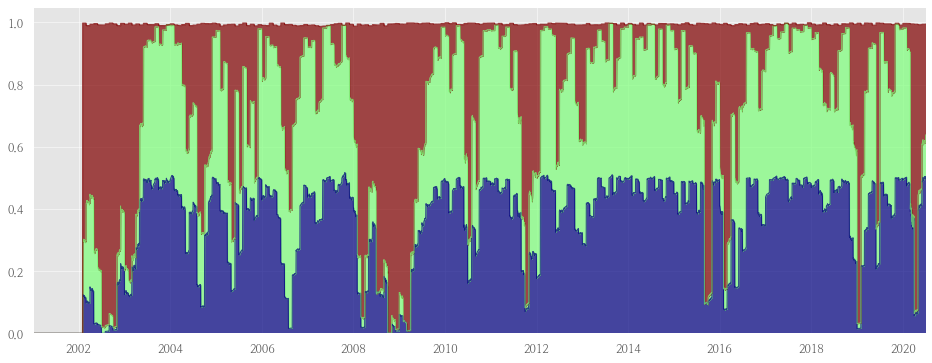

In [12]:
r.get_security_weights('나스닥다우동일비중AMS').plot.area(stacked=True, alpha=0.7, legend=False, cmap='jet', figsize=(16,6));

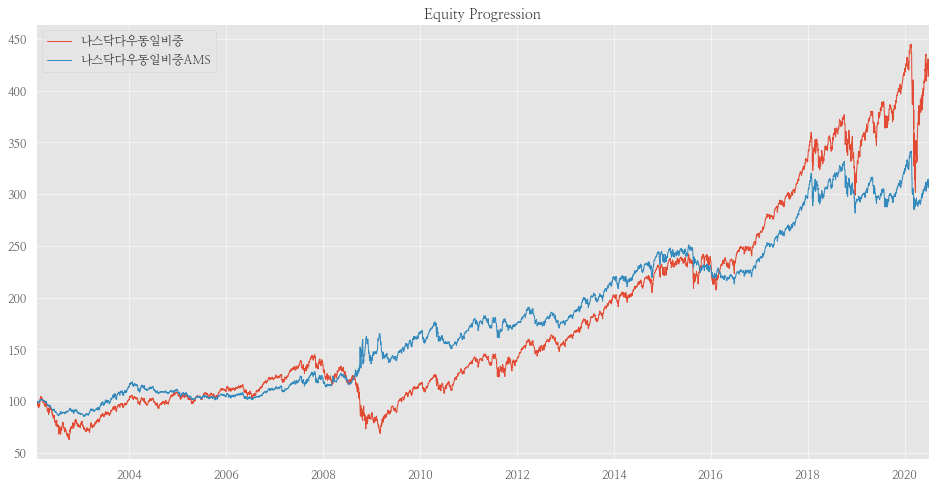

In [13]:
ax = r.plot(figsize=(16,8));
plt.legend(loc="upper left");

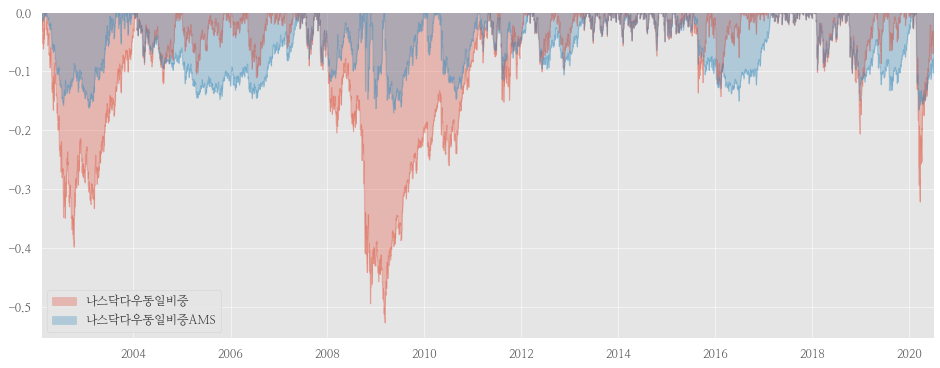

In [14]:
r.prices.to_drawdown_series().plot.area(stacked=False, alpha=0.3, figsize=(16, 6));

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2002-02-02  2002-02-02
End Period                 2020-07-02  2020-07-02
Risk-Free Rate             0.0%        0.0%
Time in Market             72.0%       70.0%

Cumulative Return          214.8%      330.86%
CAGR﹪                     6.42%       8.25%

Sharpe                     0.45        0.41
Smart Sharpe               0.43        0.39
Sortino                    0.63        0.58
Smart Sortino              0.6         0.56
Sortino/√2                 0.44        0.41
Smart Sortino/√2           0.43        0.39
Omega                      1.1         1.1

Max Drawdown               -17.1%      -52.74%
Longest DD Days            1219        1274
Volatility (ann.)          10.99%      16.94%
R^2                        0.35        0.35
Calmar                     0.38        0.16
Skew                       -0.2        0.04
Kurtosis                   22.25       16

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2009-03-03,2009-05-13,2009-12-24,296,-17.101,-16.386
2,2020-02-20,2020-03-16,2020-07-02,133,-16.576,-15.750
3,2008-11-25,2008-12-30,2009-03-02,97,-16.378,-16.209
4,2002-03-20,2003-01-27,2003-08-19,517,-16.243,-15.855
5,2015-07-21,2016-06-27,2017-03-01,589,-15.106,-13.838


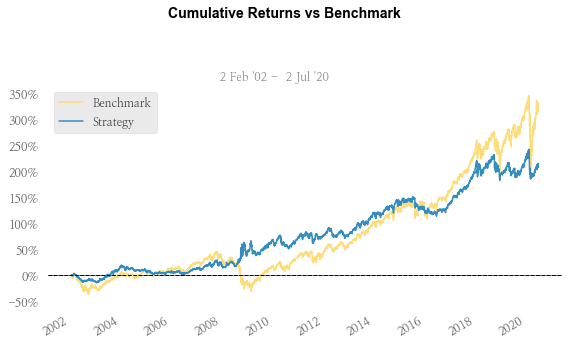

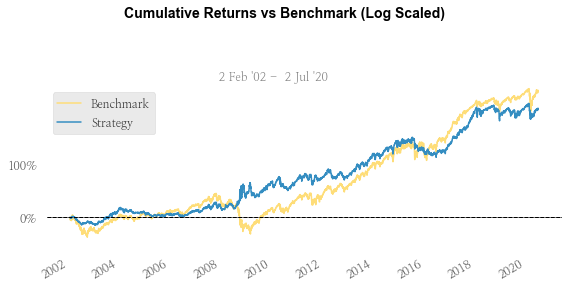

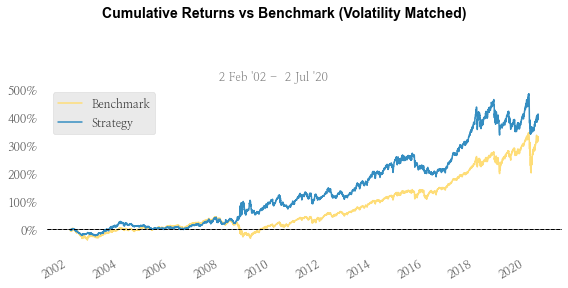

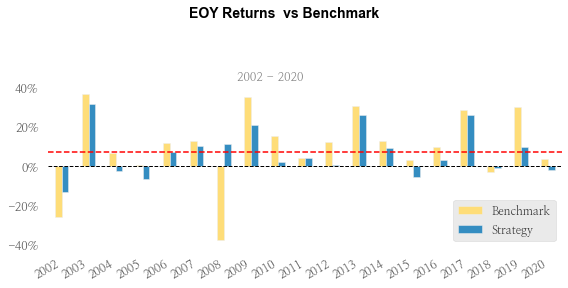

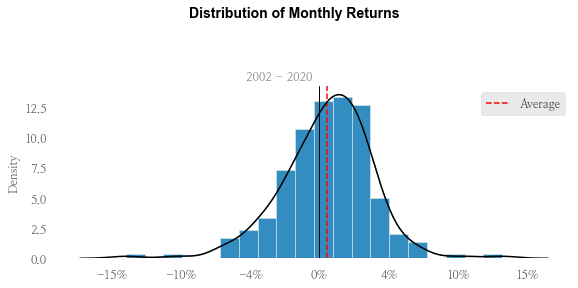

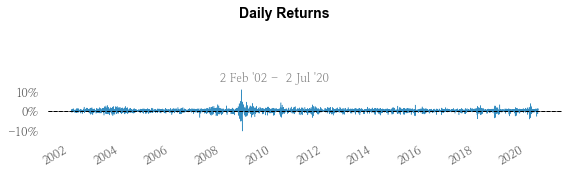

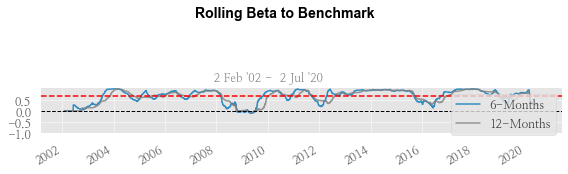

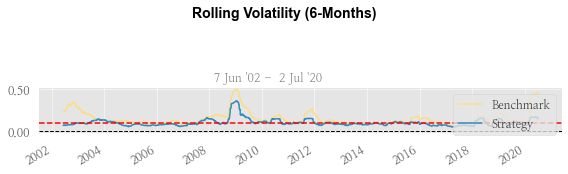

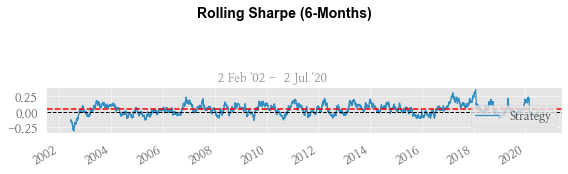

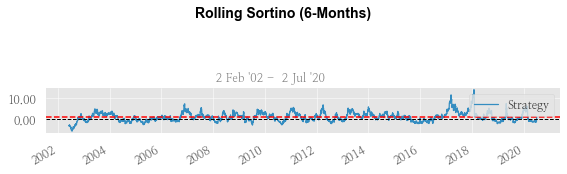

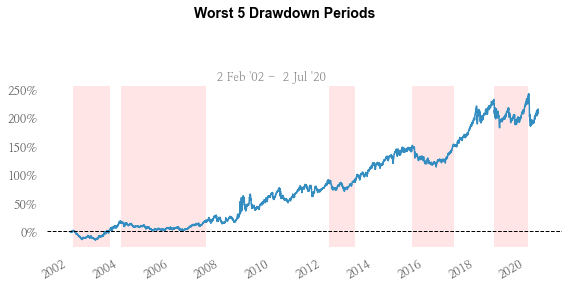

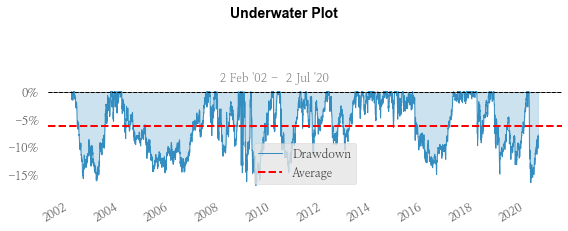

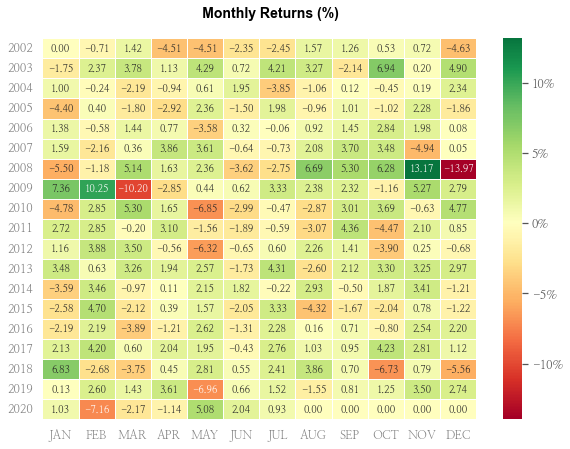

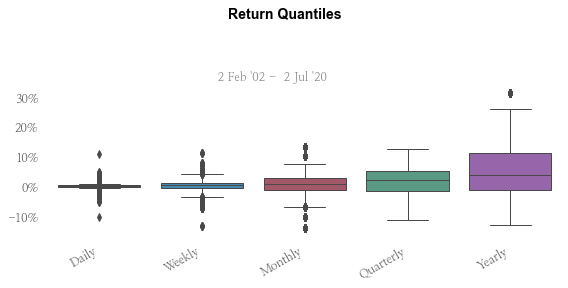

In [15]:
qs.reports.full(r['나스닥다우동일비중AMS'].prices.to_returns().dropna(), 
                r['나스닥다우동일비중'].prices.to_returns().dropna())